In [2]:
import os
import zipfile
import numpy as np
import pandas as pd
from PIL import Image
import tensorflow as tf
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import sklearn.model_selection
import random
from tensorflow.keras import layers, Model
from sklearn.model_selection import train_test_split

In [3]:
from tqdm import tqdm
tqdm.pandas()

In [4]:
# --- Data Download and Extraction ---

# To download the file
file_id = "1el92N8lBia2a5RFK0leeFQFRyhsEXaZx"
output_zip = "rare_species.zip"
extract_path = '/content/rare_species'

# Check if data already extracted
if not os.path.exists(os.path.join(extract_path, 'metadata.csv')):
    print("Downloading dataset...")
    # Use gdown Python API instead of shell command for better error handling potential
    import gdown
    gdown.download(id=file_id, output=output_zip, quiet=False)

    # Verify file size (optional, but good practice)
    print(f"Verifying {output_zip} size...")
    # Use os.path.getsize for verification
    try:
        zip_size_gb = os.path.getsize(output_zip) / (1024**3)
        print(f"{output_zip} size: {zip_size_gb:.2f} GB")
        if zip_size_gb < 3.5: # Basic check if download might be incomplete
             print("Warning: Downloaded file size seems small.")
    except OSError as e:
        print(f"Error getting file size: {e}")


    # File extraction
    if not os.path.exists(extract_path):
        os.makedirs(extract_path)
        print(f"Created directory: {extract_path}")

    print("Extracting zip...")
    try:
        with zipfile.ZipFile(output_zip, 'r') as zip_ref:
            zip_ref.extractall(extract_path)
        print("Extraction complete.")
        # Clean up the zip file after extraction
        # os.remove(output_zip)
        # print(f"Removed {output_zip}.")
    except zipfile.BadZipFile:
        print("Error: Downloaded file is not a valid zip file or is corrupted.")
    except Exception as e:
        print(f"An error occurred during extraction: {e}")
else:
    print("Dataset already downloaded and extracted.")


# --- Metadata Loading and Initial Filtering ---

# To load the csv file as metadata
metadata_path = os.path.join(extract_path, 'metadata.csv')
if os.path.exists(metadata_path):
    metadata = pd.read_csv(metadata_path)
    print(f"Loaded metadata with shape: {metadata.shape}")
    print("Original metadata head:")
    print(metadata.head())
else:
    print(f"Error: {metadata_path} not found after extraction.")
    metadata = pd.DataFrame() # Create empty dataframe to avoid later errors

if not metadata.empty:
    # Selecting columns
    columns_to_keep = ['file_path', 'family', 'phylum'] # Keep only necessary columns
    metadata = metadata[columns_to_keep]
    print('\nSelected columns:', metadata.columns.tolist())
    print("Metadata head after column selection:")
    print(metadata.head())

Downloading...
From (original): https://drive.google.com/uc?id=1el92N8lBia2a5RFK0leeFQFRyhsEXaZx
From (redirected): https://drive.google.com/uc?id=1el92N8lBia2a5RFK0leeFQFRyhsEXaZx&confirm=t&uuid=e06dcbf0-bec2-4af7-a458-7ede28764d22
To: /content/rare_species.zip
100%|██████████| 4.26G/4.26G [00:46<00:00, 90.9MB/s]


Verifying rare_species.zip size...
rare_species.zip size: 3.96 GB
Created directory: /content/rare_species
Extracting zip...
Extraction complete.
Loaded metadata with shape: (11983, 7)
Original metadata head:
                        rare_species_id  eol_content_id  eol_page_id  \
0  75fd91cb-2881-41cd-88e6-de451e8b60e2        12853737       449393   
1  28c508bc-63ff-4e60-9c8f-1934367e1528        20969394       793083   
2  00372441-588c-4af8-9665-29bee20822c0        28895411       319982   
3  29cc6040-6af2-49ee-86ec-ab7d89793828        29658536     45510188   
4  94004bff-3a33-4758-8125-bf72e6e57eab        21252576      7250886   

    kingdom    phylum            family  \
0  animalia  mollusca         unionidae   
1  animalia  chordata       geoemydidae   
2  animalia  chordata  cryptobranchidae   
3  animalia  chordata          turdidae   
4  animalia  chordata         indriidae   

                                           file_path  
0  mollusca_unionidae/12853737_449393_eol-fu

In [5]:
# --- Constants and Configuration ---

DATA_PATH = extract_path # Use the extraction path
IMG_SIZE = (224, 224)
BATCH_SIZE = 16
AUTOTUNE = tf.data.AUTOTUNE
CLASS_THRESHOLD = 10 # Minimum images per class to be considered 'not rare'
MIN_RESOLUTION = (100, 100) # Minimum image dimensions
TRAIN_SPLIT = 0.7 # *** UPDATED *** Train split ratio
VAL_SPLIT = 0.3 # *** UPDATED *** Validation split ratio
EPOCHS = 25 #Number of training epochs

# Define a seed for replications
SEED = 42 # Changed seed for potential variation if rerunning
tf.random.set_seed(SEED)
np.random.seed(SEED)

# Define the mean and the standard deviation expected for ImageNet models (RGB patterns)
IMAGENET_MEAN = tf.constant([0.485, 0.456, 0.406], dtype=tf.float32)
IMAGENET_STD = tf.constant([0.229, 0.224, 0.225], dtype=tf.float32)


In [6]:
# --- Data Validation and Preprocessing Functions ---

def image_validator(path, min_resolution=MIN_RESOLUTION):
    """
    Checks whether an image exists, is readable, and meets a minimum resolution.

    Requires:
        - path (str): Full path to the image file.
        - min_resolution (tuple): Minimum resolution as (width, height).

    Ensures:
        - Returns True if the image exists, is readable, and meets the resolution requirement.
        - Returns False otherwise (missing, unreadable, or low-resolution image).
    """
    if not os.path.exists(path):
        # print(f"Warning: Image path does not exist: {path}") # Optional: uncomment for verbose warnings
        return False
    try:
        with Image.open(path) as img:
            # Check resolution
            if img.size[0] < min_resolution[0] or img.size[1] < min_resolution[1]:
                # print(f"Warning: Image below min resolution {min_resolution}: {path} ({img.size})") # Optional
                return False
            # Verify image can be opened without error (basic check)
            img.verify()
            # Reopen after verify
            img = Image.open(path)
            # Check if image can be loaded/decoded by TF (more robust but slower)
            # try:
            #     tf_img = tf.io.read_file(path)
            #     # Use decode_image for flexibility with formats (png, gif etc.)
            #     tf.image.decode_image(tf_img, channels=3)
            # except tf.errors.InvalidArgumentError:
            #     # print(f"Warning: TensorFlow could not decode image: {path}") # Optional
            #     return False
            return True
    except (IOError, SyntaxError, tf.errors.InvalidArgumentError) as e: # Catch common PIL/TF errors
        # print(f"Warning: Error opening or validating image {path}: {e}") # Optional
        return False
    except Exception as e: # Catch unexpected errors
        # print(f"Warning: Unexpected error validating image {path}: {e}") # Optional
        return False

In [7]:
def load_and_validate_data(data_path, metadata_df):
    """
    Validates image entries in the metadata DataFrame.

    Requires:
        - data_path (str): Base path where image subdirectories are located.
        - metadata_df (pd.DataFrame): DataFrame containing 'file_path'.

    Ensures:
        - Returns a cleaned DataFrame with only valid image entries.
        - Adds a 'full_path' column with the absolute path to each image.
        - Removes entries for images that don't exist, are unreadable, or below MIN_RESOLUTION.
    """
    if metadata_df.empty:
        print("Metadata is empty, skipping validation.")
        return metadata_df

    print("Validating image paths and resolutions...")
    metadata_df['full_path'] = metadata_df['file_path'].apply(lambda x: os.path.join(data_path, x))

    # Apply validation using pandas progress_apply
    metadata_df['valid'] = metadata_df['full_path'].progress_apply(lambda x: image_validator(x, MIN_RESOLUTION))

    valid_count = metadata_df['valid'].sum()
    total_count = len(metadata_df)
    print(f"\nValidation complete. Found {valid_count} valid images out of {total_count}.")
    print(f"Removing {total_count - valid_count} invalid entries.")

    return metadata_df[metadata_df['valid']].drop(columns=['valid']).reset_index(drop=True)

In [8]:
def analyze_class_distribution(metadata_df):
    """
    Plots the distribution of image counts per family and prints rare classes.

    Requires:
        - metadata_df (pd.DataFrame): Must include a 'family' column.
        - CLASS_THRESHOLD (int): Global variable defining 'rare' class threshold.

    Ensures:
        - Displays a histogram showing image counts per family.
        - Prints the number of families with fewer than CLASS_THRESHOLD images.
    """
    if metadata_df.empty or 'family' not in metadata_df.columns:
        print("Metadata is empty or missing 'family' column, skipping distribution analysis.")
        return None # Return None or empty counts

    print("\nAnalyzing class distribution ('family')...")
    family_counts = metadata_df['family'].value_counts()

    plt.figure(figsize=(12, 6))
    sns.histplot(family_counts, bins=max(50, len(family_counts)//10)) # Adjust bins based on number of families
    plt.title("Images per Family Distribution")
    plt.xlabel("Number of Images")
    plt.ylabel("Number of Families")
    plt.grid(axis='y', linestyle='--')
    plt.tight_layout()
    plt.show()

    rare_classes = family_counts[family_counts < CLASS_THRESHOLD]
    print(f"Number of families: {len(family_counts)}")
    print(f"Families with fewer than {CLASS_THRESHOLD} images: {len(rare_classes)}")
    if len(rare_classes) > 0:
        print("Examples of rare families:")
        print(rare_classes.head())
    return family_counts # Return the counts for potential further use

In [9]:
def create_datasets(metadata_df, augment_version='v1'):
    """
    Prepares train and validation datasets from metadata, applying preprocessing and selected augmentation version.

    Args:
        metadata_df (DataFrame): Cleaned metadata with 'full_path', 'family', 'phylum'.
        augment_version (str): One of 'v1', 'v2', or 'v3' indicating which augmentation strategy to use.

    Returns:
        train_ds (tf.data.Dataset)
        val_ds (tf.data.Dataset)
        family_lookup (tf.keras.layers.StringLookup)
        phylum_lookup (tf.keras.layers.StringLookup)
        train_fams (np.array)
        val_fams (np.array)
    """
    if metadata_df.empty:
         print("Metadata is empty, cannot create datasets.")
         return None, None, None, None, None, None

    print("\nCreating datasets...")
    family_labels = metadata_df['family'].values
    phylum_labels = metadata_df['phylum'].values

    print(f"Splitting data ({int(TRAIN_SPLIT*100)}% train, {int(VAL_SPLIT*100)}% validation), stratified by 'family'...")
    train_df, val_df = train_test_split(
        metadata_df,
        test_size=VAL_SPLIT,
        stratify=family_labels,
        random_state=SEED
    )
    if train_df.empty or val_df.empty:
        print("Error: Train or validation DataFrame is empty after split.")
        return None, None, None, None, None, None

    train_paths = train_df['full_path'].values
    train_fams = train_df['family'].values
    train_phylums = train_df['phylum'].values

    val_paths = val_df['full_path'].values
    val_fams = val_df['family'].values
    val_phylums = val_df['phylum'].values

    print("Creating StringLookup layers...")
    all_families = sorted(list(np.unique(family_labels)))
    all_phyla = sorted(list(np.unique(phylum_labels)))

    family_lookup = tf.keras.layers.StringLookup(vocabulary=all_families, mask_token=None, oov_token=None)
    phylum_lookup = tf.keras.layers.StringLookup(vocabulary=all_phyla, mask_token=None, oov_token=None)

    print(f"Unique families: {family_lookup.vocabulary_size()}, Unique phyla: {phylum_lookup.vocabulary_size()}")

    def preprocess(file_path, family, phylum):
        try:
            img = tf.io.read_file(file_path)
            img = tf.image.decode_jpeg(img, channels=3)
            img = tf.image.resize(img, IMG_SIZE, method=tf.image.ResizeMethod.BILINEAR)
            img = tf.cast(img, tf.float32) / 255.0
            img = (img - IMAGENET_MEAN) / IMAGENET_STD
            img = tf.ensure_shape(img, [IMG_SIZE[0], IMG_SIZE[1], 3])

            phylum_idx = phylum_lookup(phylum)
            family_idx = family_lookup(family)

            return (img, tf.cast(phylum_idx, tf.int64)), tf.cast(family_idx, tf.int64)
        except Exception as e:
            tf.print(f"Error processing file {file_path}: {e}")
            dummy_img = tf.zeros([IMG_SIZE[0], IMG_SIZE[1], 3], dtype=tf.float32)
            return (dummy_img, tf.constant(0, tf.int64)), tf.constant(0, tf.int64)

    def augment_v1(image_phylum, label):
        image, phylum = image_phylum
        image = tf.image.random_flip_left_right(image, seed=SEED)
        image = tf.image.random_brightness(image, max_delta=0.2, seed=SEED)
        image = tf.image.rot90(image, tf.random.uniform([], 0, 4, dtype=tf.int32, seed=SEED))
        return (tf.ensure_shape(image, [IMG_SIZE[0], IMG_SIZE[1], 3]), phylum), label

    def augment_v2(image_phylum, label):
        image, phylum = image_phylum
        image = tf.image.random_saturation(image, lower=0.8, upper=1.2, seed=SEED)
        image = tf.image.random_flip_left_right(image, seed=SEED)
        image = tf.image.random_contrast(image, lower=0.75, upper=1.25, seed=SEED)
        return (tf.ensure_shape(image, [IMG_SIZE[0], IMG_SIZE[1], 3]), phylum), label

    def augment_v3(image_phylum, label):
        image, phylum = image_phylum
        image = tf.image.random_flip_up_down(image, seed=SEED)
        image = tf.image.random_hue(image, max_delta=0.05, seed=SEED)
        image = tf.image.random_jpeg_quality(image, 80, 100, seed=SEED)
        return (tf.ensure_shape(image, [IMG_SIZE[0], IMG_SIZE[1], 3]), phylum), label

    def make_dataset(paths, families, phyla, apply_augmentation=False, augmentation_fn=None):
        ds = tf.data.Dataset.from_tensor_slices((paths, families, phyla))
        if apply_augmentation:
            ds = ds.shuffle(buffer_size=len(paths), seed=SEED, reshuffle_each_iteration=True)

        ds = ds.map(preprocess, num_parallel_calls=AUTOTUNE)

        if apply_augmentation and augmentation_fn:
            ds = ds.map(augmentation_fn, num_parallel_calls=AUTOTUNE)

        ds = ds.batch(BATCH_SIZE)
        ds = ds.prefetch(buffer_size=AUTOTUNE)
        return ds

    # Select augmentation function
    if augment_version == 'v1':
        aug_fn = augment_v1
    elif augment_version == 'v2':
        aug_fn = augment_v2
    elif augment_version == 'v3':
        aug_fn = augment_v3
    else:
        raise ValueError(f"Unknown augment_version: {augment_version}")

    print(f"Building training dataset with augmentation version '{augment_version}'...")
    train_ds = make_dataset(train_paths, train_fams, train_phylums, apply_augmentation=True, augmentation_fn=aug_fn)

    print("Building validation dataset...")
    val_ds = make_dataset(val_paths, val_fams, val_phylums, apply_augmentation=False)

    print("Dataset creation finished.")
    return train_ds, val_ds, family_lookup, phylum_lookup, train_fams, val_fams


# AUGMENTATION VERSION 1

Validating image paths and resolutions...


 85%|████████▌ | 10188/11983 [00:09<00:01, 1274.19it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
100%|██████████| 11983/11983 [00:11<00:00, 1065.89it/s]



Validation complete. Found 11983 valid images out of 11983.
Removing 0 invalid entries.

Analyzing class distribution ('family')...


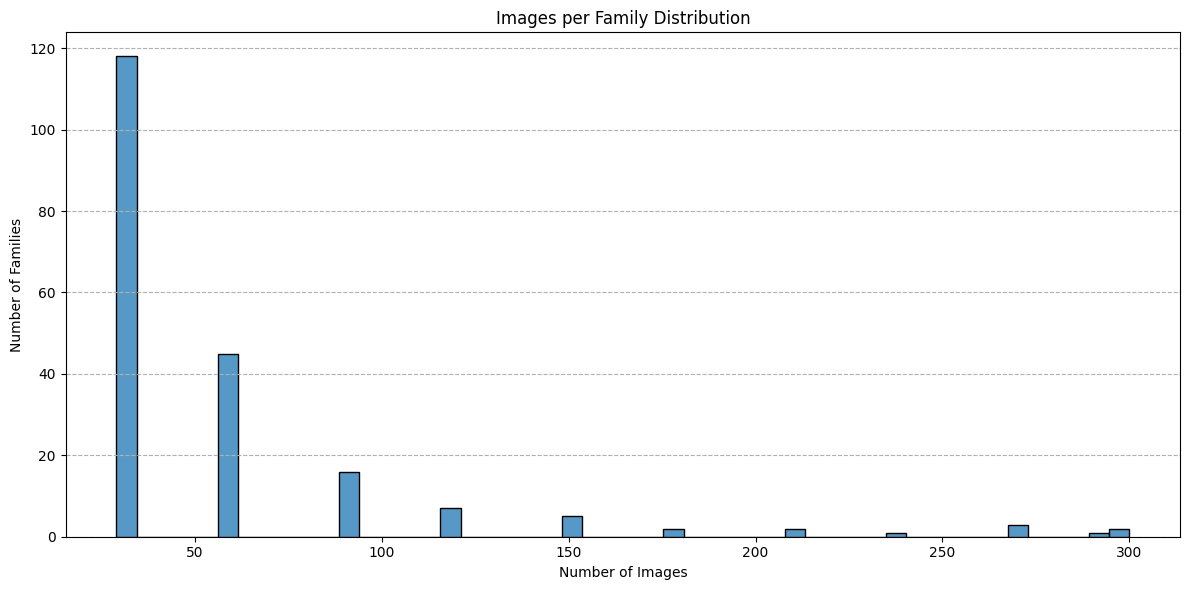

Number of families: 202
Families with fewer than 10 images: 0

Creating datasets...
Splitting data (70% train, 30% validation), stratified by 'family'...
Creating StringLookup layers...
Unique families: 203, Unique phyla: 6
Building training dataset with augmentation version 'v1'...
Building validation dataset...
Dataset creation finished.

Number of family classes: 203
Number of phylum classes: 6

Inspecting a batch from the training dataset:
Images batch shape: (16, 224, 224, 3)
Phyla indices batch shape: (16,)
Family indices batch shape: (16,)


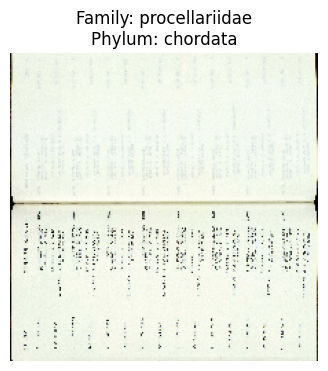

Images batch shape: (16, 224, 224, 3)
Phyla indices batch shape: (16,)
Family indices batch shape: (16,)


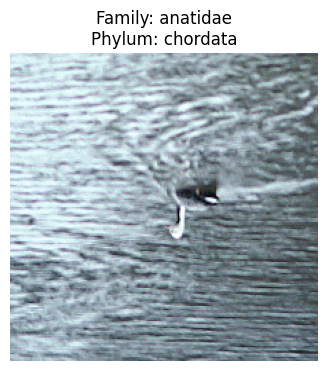

Images batch shape: (16, 224, 224, 3)
Phyla indices batch shape: (16,)
Family indices batch shape: (16,)


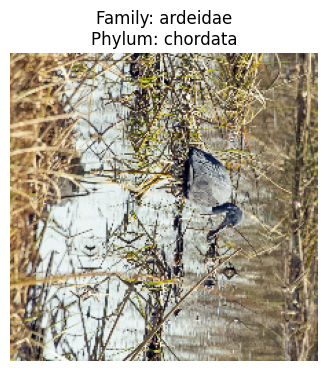

Images batch shape: (16, 224, 224, 3)
Phyla indices batch shape: (16,)
Family indices batch shape: (16,)


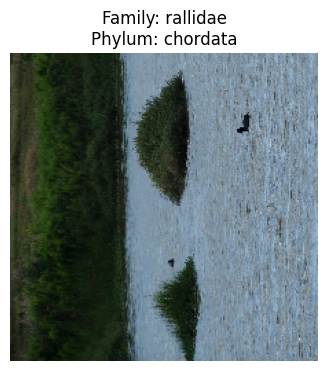

Images batch shape: (16, 224, 224, 3)
Phyla indices batch shape: (16,)
Family indices batch shape: (16,)


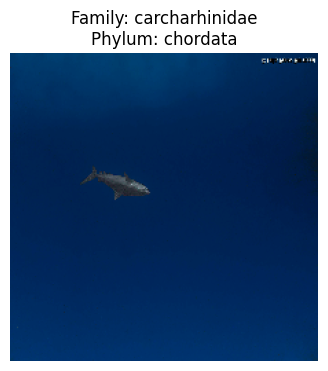

Images batch shape: (16, 224, 224, 3)
Phyla indices batch shape: (16,)
Family indices batch shape: (16,)


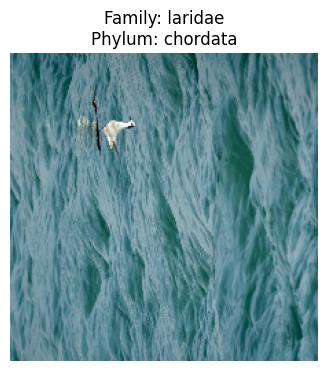

Images batch shape: (16, 224, 224, 3)
Phyla indices batch shape: (16,)
Family indices batch shape: (16,)


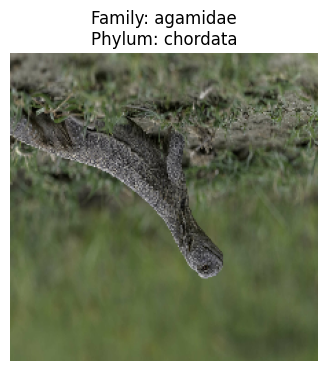

Images batch shape: (16, 224, 224, 3)
Phyla indices batch shape: (16,)
Family indices batch shape: (16,)


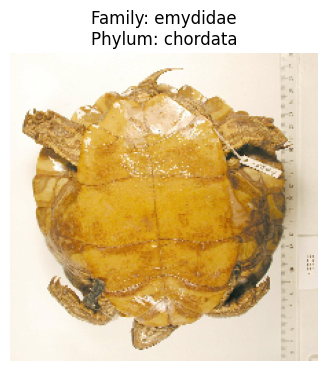

Images batch shape: (16, 224, 224, 3)
Phyla indices batch shape: (16,)
Family indices batch shape: (16,)


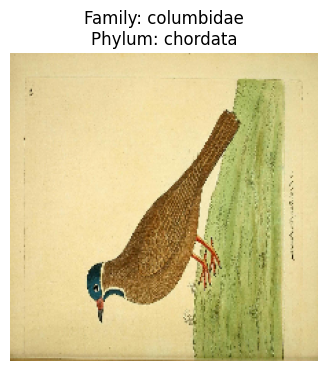

Images batch shape: (16, 224, 224, 3)
Phyla indices batch shape: (16,)
Family indices batch shape: (16,)


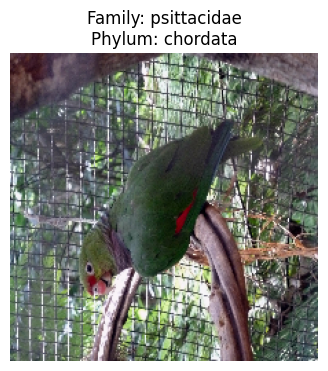

In [10]:
if not metadata.empty:
    # Validate data
    metadata_validated = load_and_validate_data(DATA_PATH, metadata.copy()) # Use copy to avoid modifying original

    if not metadata_validated.empty:
        # Analyze distribution of validated data
        analyze_class_distribution(metadata_validated)

        # Create datasets using validated data
        # This line calls create_datasets and unpacks its return values
        train_ds, val_ds, family_lookup, phylum_lookup, train_fams, val_fams = create_datasets(metadata_validated, augment_version='v1')

        # Check if datasets were created successfully
        # The check below handles the case where create_datasets returned None due to empty split
        if train_ds and val_ds and family_lookup and phylum_lookup:
            NUM_FAMILIES = family_lookup.vocabulary_size()
            NUM_PHYLA = phylum_lookup.vocabulary_size()
            print(f"\nNumber of family classes: {NUM_FAMILIES}")
            print(f"Number of phylum classes: {NUM_PHYLA}")

            # Optional: Inspect a batch from the training dataset
            print("\nInspecting a batch from the training dataset:")
            for (images, phyla_indices), family_indices in train_ds.take(10):
                print("Images batch shape:", images.shape)
                print("Phyla indices batch shape:", phyla_indices.shape)
                print("Family indices batch shape:", family_indices.shape)
                # Display the first image in the batch
                plt.figure(figsize=(4, 4))
                # Denormalize image for display: (image * std) + mean
                display_img = (images[0].numpy() * IMAGENET_STD.numpy() + IMAGENET_MEAN.numpy()).clip(0, 1)
                plt.imshow(display_img)
                # Get the string labels for the first item
                fam_label_idx = family_indices[0].numpy()
                phy_label_idx = phyla_indices[0].numpy()
                # Handle potential index out of bounds if lookup failed for some reason
                fam_label = family_lookup.get_vocabulary()[fam_label_idx] if fam_label_idx < NUM_FAMILIES else "Unknown"
                phy_label = phylum_lookup.get_vocabulary()[phy_label_idx] if phy_label_idx < NUM_PHYLA else "Unknown"
                plt.title(f"Family: {fam_label}\nPhylum: {phy_label}")
                plt.axis("off")
                plt.show()
        else:
            print("Failed to create datasets or unpack results from create_datasets.")
            # Set flags or exit if datasets are crucial
            # sys.exit("Dataset creation failed.")
    else:
        print("No valid data found after validation.")
        # sys.exit("No valid data.")
else:
    print("Metadata loading failed, cannot proceed.")
    # sys.exit("Metadata loading failed.")

In [11]:
def build_custom_cnn(num_phyla, num_families):
    """
    Builds a simple custom CNN model for image classification with auxiliary phylum input.

    Requires:
        - num_phyla (int): Number of unique phylum classes (for embedding layer).
        - num_families (int): Number of output classes (families) for softmax classification.

    Ensures:
        - Image input passes through 3 convolutional + pooling blocks.
        - Phylum input is embedded and concatenated with visual features.
        - Fully connected layers apply dropout regularization to prevent overfitting.
        - Output layer predicts one of the family classes via softmax.

    Returns:
        - model (tf.keras.Model): Compiled Keras model ready for training.
    """

    img_input = tf.keras.Input(shape=(224, 224, 3), name="image")
    phylum_input = tf.keras.Input(shape=(), dtype=tf.int32, name="phylum")

    x = tf.keras.layers.Conv2D(32, 3, activation='relu', padding='same')(img_input)
    x = tf.keras.layers.MaxPooling2D()(x)
    x = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(x)
    x = tf.keras.layers.MaxPooling2D()(x)
    x = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(x)
    x = tf.keras.layers.Flatten()(x)

    phylum_embed = tf.keras.layers.Embedding(input_dim=num_phyla, output_dim=16)(phylum_input)
    phylum_embed = tf.keras.layers.Flatten()(phylum_embed)

    concat = tf.keras.layers.Concatenate()([x, phylum_embed])
    x = tf.keras.layers.Dense(256, activation='relu')(concat)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    output = tf.keras.layers.Dense(num_families, activation='softmax')(x)

    return tf.keras.Model(inputs=[img_input, phylum_input], outputs=output, name="CustomCNN")

Epoch 1/20
525/525 ━━━━━━━━━━━━━━━━━━━━ 234s 438ms/step - accuracy: 0.0269 - loss: 6.2224 - val_accuracy: 0.0668 - val_loss: 4.6135
Epoch 2/20
525/525 ━━━━━━━━━━━━━━━━━━━━ 228s 434ms/step - accuracy: 0.0621 - loss: 4.5776 - val_accuracy: 0.0801 - val_loss: 4.4156
Epoch 3/20
525/525 ━━━━━━━━━━━━━━━━━━━━ 269s 447ms/step - accuracy: 0.0690 - loss: 4.4620 - val_accuracy: 0.0912 - val_loss: 4.3586
Epoch 4/20
525/525 ━━━━━━━━━━━━━━━━━━━━ 233s 444ms/step - accuracy: 0.0935 - loss: 4.4001 - val_accuracy: 0.0979 - val_loss: 4.3346
Epoch 5/20
525/525 ━━━━━━━━━━━━━━━━━━━━ 266s 453ms/step - accuracy: 0.0941 - loss: 4.3262 - val_accuracy: 0.0954 - val_loss: 4.2624
Epoch 6/20
525/525 ━━━━━━━━━━━━━━━━━━━━ 260s 450ms/step - accuracy: 0.1036 - loss: 4.2086 - val_accuracy: 0.1146 - val_loss: 4.2010
Epoch 7/20
525/525 ━━━━━━━━━━━━━━━━━━━━ 238s 453ms/step - accuracy: 0.1212 - loss: 4.1501 - val_accuracy: 0.1113 - val_loss: 4.1520
Epoch 8/20
525/525 ━━━━━━━━━━━━━━━━━━━━ 258s 445ms/step - accuracy: 0.1310 -

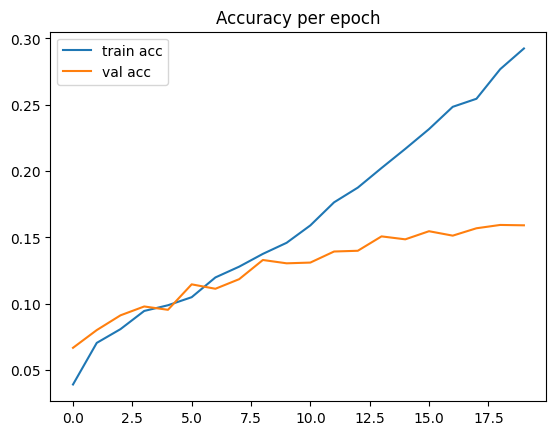

In [13]:
model_cnn = build_custom_cnn(NUM_PHYLA, NUM_FAMILIES)

# Compile the model
model_cnn.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",  # For multi-class classification
    metrics=["accuracy"]
)

history = model_cnn.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
    ]
)

plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.title("Accuracy per epoch")
plt.show()

# AUGMENTATION VERSION 2

Validating image paths and resolutions...


 83%|████████▎ | 9979/11983 [00:03<00:00, 4924.23it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
100%|██████████| 11983/11983 [00:03<00:00, 3489.26it/s]



Validation complete. Found 11983 valid images out of 11983.
Removing 0 invalid entries.

Analyzing class distribution ('family')...


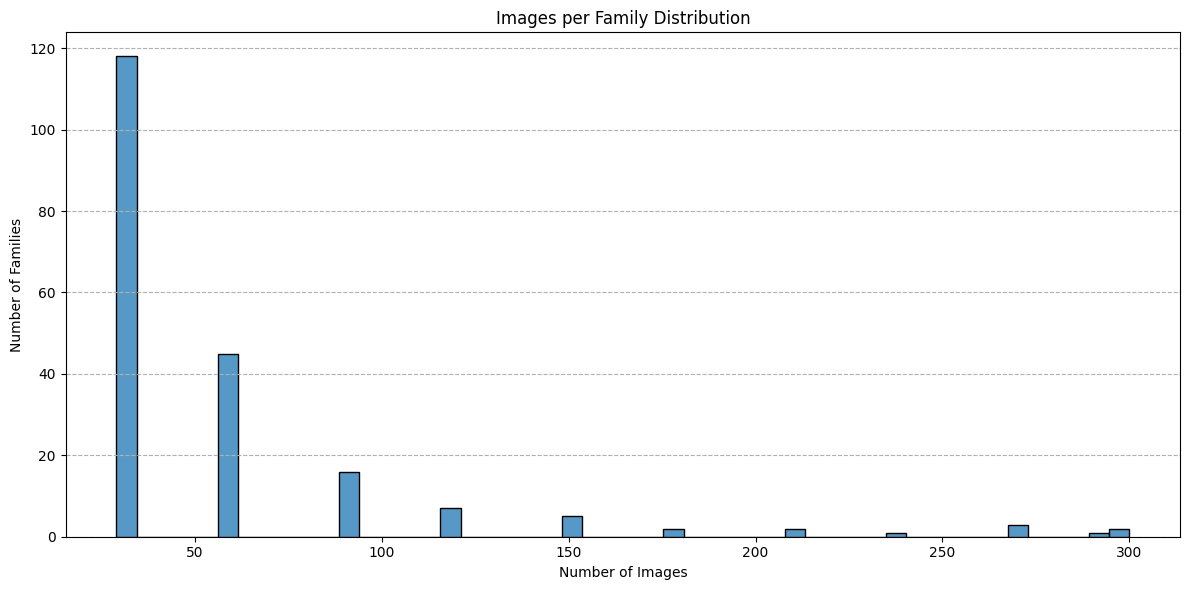

Number of families: 202
Families with fewer than 10 images: 0

Creating datasets...
Splitting data (70% train, 30% validation), stratified by 'family'...
Creating StringLookup layers...
Unique families: 203, Unique phyla: 6
Building training dataset with augmentation version 'v2'...
Building validation dataset...
Dataset creation finished.

Number of family classes: 203
Number of phylum classes: 6

Inspecting a batch from the training dataset:
Images batch shape: (16, 224, 224, 3)
Phyla indices batch shape: (16,)
Family indices batch shape: (16,)


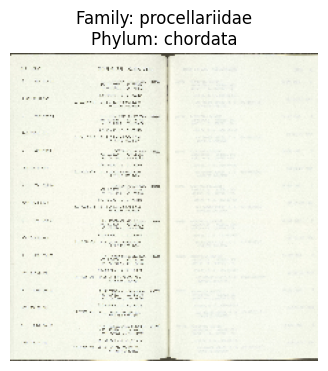

Images batch shape: (16, 224, 224, 3)
Phyla indices batch shape: (16,)
Family indices batch shape: (16,)


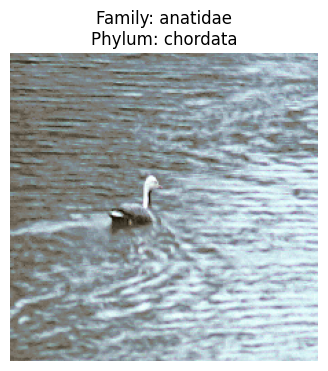

Images batch shape: (16, 224, 224, 3)
Phyla indices batch shape: (16,)
Family indices batch shape: (16,)


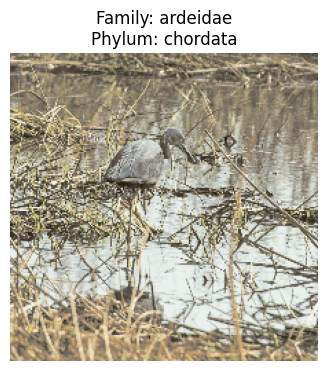

Images batch shape: (16, 224, 224, 3)
Phyla indices batch shape: (16,)
Family indices batch shape: (16,)


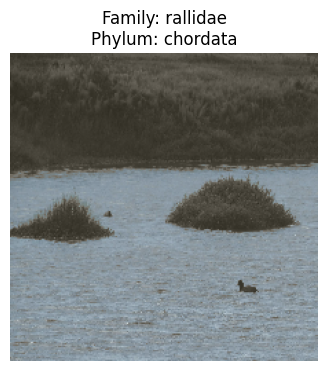

Images batch shape: (16, 224, 224, 3)
Phyla indices batch shape: (16,)
Family indices batch shape: (16,)


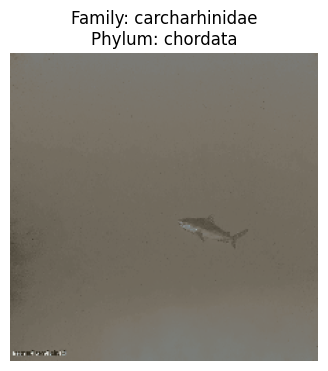

Images batch shape: (16, 224, 224, 3)
Phyla indices batch shape: (16,)
Family indices batch shape: (16,)


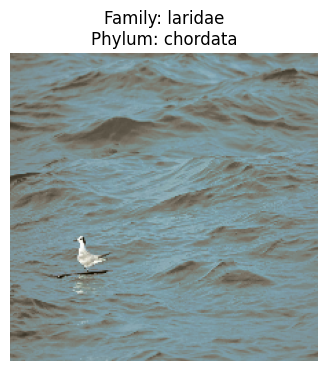

Images batch shape: (16, 224, 224, 3)
Phyla indices batch shape: (16,)
Family indices batch shape: (16,)


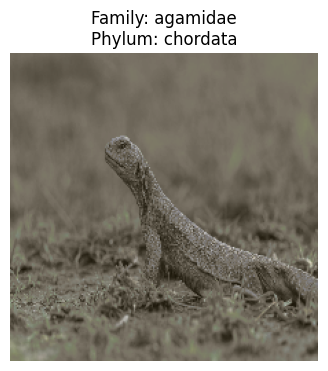

Images batch shape: (16, 224, 224, 3)
Phyla indices batch shape: (16,)
Family indices batch shape: (16,)


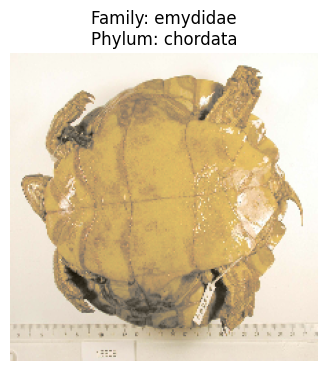

Images batch shape: (16, 224, 224, 3)
Phyla indices batch shape: (16,)
Family indices batch shape: (16,)


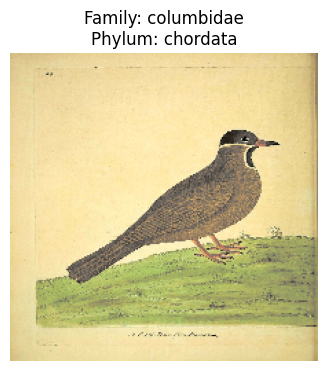

Images batch shape: (16, 224, 224, 3)
Phyla indices batch shape: (16,)
Family indices batch shape: (16,)


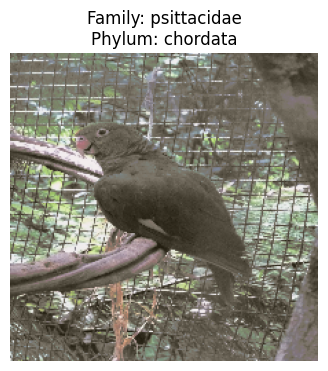

In [14]:
if not metadata.empty:
    # Validate data
    metadata_validated = load_and_validate_data(DATA_PATH, metadata.copy()) # Use copy to avoid modifying original

    if not metadata_validated.empty:
        # Analyze distribution of validated data
        analyze_class_distribution(metadata_validated)

        # Create datasets using validated data
        # This line calls create_datasets and unpacks its return values
        train_ds, val_ds, family_lookup, phylum_lookup, train_fams, val_fams = create_datasets(metadata_validated, augment_version='v2')

        # Check if datasets were created successfully
        # The check below handles the case where create_datasets returned None due to empty split
        if train_ds and val_ds and family_lookup and phylum_lookup:
            NUM_FAMILIES = family_lookup.vocabulary_size()
            NUM_PHYLA = phylum_lookup.vocabulary_size()
            print(f"\nNumber of family classes: {NUM_FAMILIES}")
            print(f"Number of phylum classes: {NUM_PHYLA}")

            # Optional: Inspect a batch from the training dataset
            print("\nInspecting a batch from the training dataset:")
            for (images, phyla_indices), family_indices in train_ds.take(10):
                print("Images batch shape:", images.shape)
                print("Phyla indices batch shape:", phyla_indices.shape)
                print("Family indices batch shape:", family_indices.shape)
                # Display the first image in the batch
                plt.figure(figsize=(4, 4))
                # Denormalize image for display: (image * std) + mean
                display_img = (images[0].numpy() * IMAGENET_STD.numpy() + IMAGENET_MEAN.numpy()).clip(0, 1)
                plt.imshow(display_img)
                # Get the string labels for the first item
                fam_label_idx = family_indices[0].numpy()
                phy_label_idx = phyla_indices[0].numpy()
                # Handle potential index out of bounds if lookup failed for some reason
                fam_label = family_lookup.get_vocabulary()[fam_label_idx] if fam_label_idx < NUM_FAMILIES else "Unknown"
                phy_label = phylum_lookup.get_vocabulary()[phy_label_idx] if phy_label_idx < NUM_PHYLA else "Unknown"
                plt.title(f"Family: {fam_label}\nPhylum: {phy_label}")
                plt.axis("off")
                plt.show()
        else:
            print("Failed to create datasets or unpack results from create_datasets.")
            # Set flags or exit if datasets are crucial
            # sys.exit("Dataset creation failed.")
    else:
        print("No valid data found after validation.")
        # sys.exit("No valid data.")
else:
    print("Metadata loading failed, cannot proceed.")
    # sys.exit("Metadata loading failed.")

In [15]:
def build_custom_cnn(num_phyla, num_families):
    """
    Builds a simple custom CNN model for image classification with auxiliary phylum input.

    Requires:
        - num_phyla (int): Number of unique phylum classes (for embedding layer).
        - num_families (int): Number of output classes (families) for softmax classification.

    Ensures:
        - Image input passes through 3 convolutional + pooling blocks.
        - Phylum input is embedded and concatenated with visual features.
        - Fully connected layers apply dropout regularization to prevent overfitting.
        - Output layer predicts one of the family classes via softmax.

    Returns:
        - model (tf.keras.Model): Compiled Keras model ready for training.
    """

    img_input = tf.keras.Input(shape=(224, 224, 3), name="image")
    phylum_input = tf.keras.Input(shape=(), dtype=tf.int32, name="phylum")

    x = tf.keras.layers.Conv2D(32, 3, activation='relu', padding='same')(img_input)
    x = tf.keras.layers.MaxPooling2D()(x)
    x = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(x)
    x = tf.keras.layers.MaxPooling2D()(x)
    x = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(x)
    x = tf.keras.layers.Flatten()(x)

    phylum_embed = tf.keras.layers.Embedding(input_dim=num_phyla, output_dim=16)(phylum_input)
    phylum_embed = tf.keras.layers.Flatten()(phylum_embed)

    concat = tf.keras.layers.Concatenate()([x, phylum_embed])
    x = tf.keras.layers.Dense(256, activation='relu')(concat)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    output = tf.keras.layers.Dense(num_families, activation='softmax')(x)

    return tf.keras.Model(inputs=[img_input, phylum_input], outputs=output, name="CustomCNN")

Epoch 1/20
525/525 ━━━━━━━━━━━━━━━━━━━━ 243s 452ms/step - accuracy: 0.0254 - loss: 6.0598 - val_accuracy: 0.0587 - val_loss: 4.6214
Epoch 2/20
525/525 ━━━━━━━━━━━━━━━━━━━━ 253s 440ms/step - accuracy: 0.0724 - loss: 4.5561 - val_accuracy: 0.0768 - val_loss: 4.3945
Epoch 3/20
525/525 ━━━━━━━━━━━━━━━━━━━━ 235s 448ms/step - accuracy: 0.0821 - loss: 4.4206 - val_accuracy: 0.0898 - val_loss: 4.3330
Epoch 4/20
525/525 ━━━━━━━━━━━━━━━━━━━━ 265s 455ms/step - accuracy: 0.0970 - loss: 4.2851 - val_accuracy: 0.1043 - val_loss: 4.2306
Epoch 5/20
525/525 ━━━━━━━━━━━━━━━━━━━━ 235s 447ms/step - accuracy: 0.1114 - loss: 4.1848 - val_accuracy: 0.1229 - val_loss: 4.1860
Epoch 6/20
525/525 ━━━━━━━━━━━━━━━━━━━━ 232s 442ms/step - accuracy: 0.1519 - loss: 3.9596 - val_accuracy: 0.1302 - val_loss: 4.1635
Epoch 7/20
525/525 ━━━━━━━━━━━━━━━━━━━━ 211s 402ms/step - accuracy: 0.1903 - loss: 3.7173 - val_accuracy: 0.1318 - val_loss: 4.1843
Epoch 8/20
525/525 ━━━━━━━━━━━━━━━━━━━━ 230s 438ms/step - accuracy: 0.2495 -

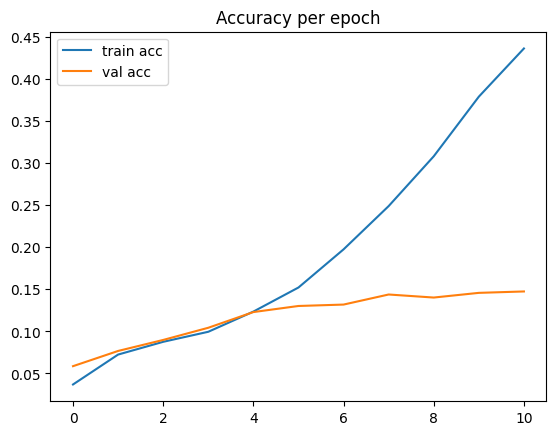

In [16]:
model_cnn2 = build_custom_cnn(NUM_PHYLA, NUM_FAMILIES)

# Compile the model
model_cnn2.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",  # For multi-class classification
    metrics=["accuracy"]
)

history = model_cnn2.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
    ]
)

plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.title("Accuracy per epoch")
plt.show()

# AUGMENTATION VERSION 3

Validating image paths and resolutions...


 83%|████████▎ | 9901/11983 [00:03<00:00, 4197.47it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3402: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
100%|██████████| 11983/11983 [00:03<00:00, 3317.43it/s]



Validation complete. Found 11983 valid images out of 11983.
Removing 0 invalid entries.

Analyzing class distribution ('family')...


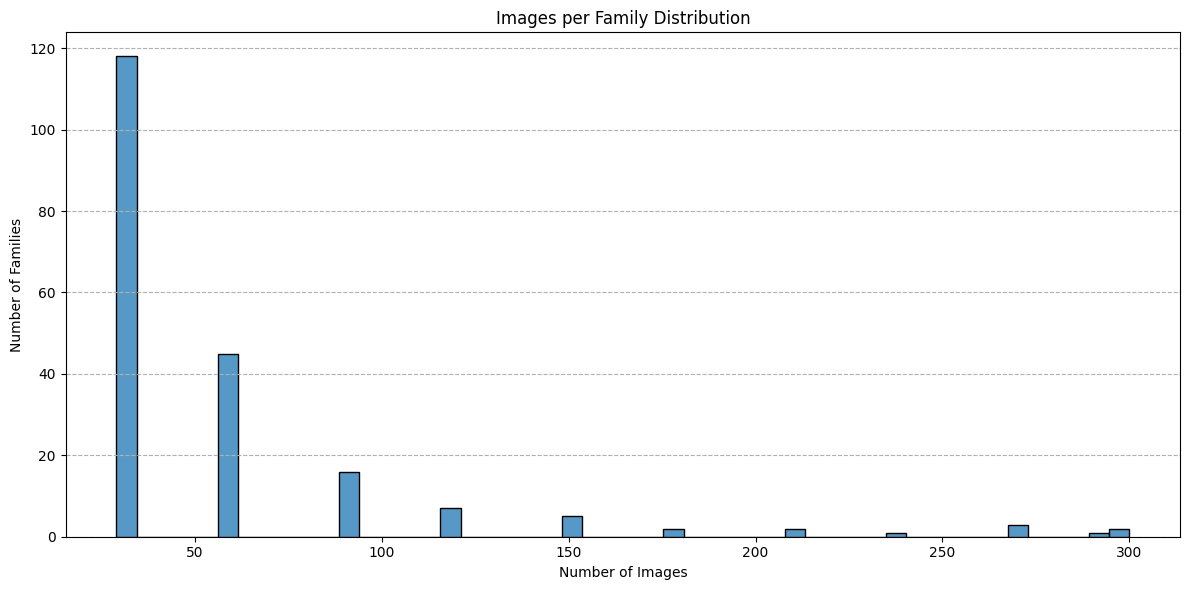

Number of families: 202
Families with fewer than 10 images: 0

Creating datasets...
Splitting data (70% train, 30% validation), stratified by 'family'...
Creating StringLookup layers...
Unique families: 203, Unique phyla: 6
Building training dataset with augmentation version 'v3'...
Building validation dataset...
Dataset creation finished.

Number of family classes: 203
Number of phylum classes: 6

Inspecting a batch from the training dataset:
Images batch shape: (16, 224, 224, 3)
Phyla indices batch shape: (16,)
Family indices batch shape: (16,)


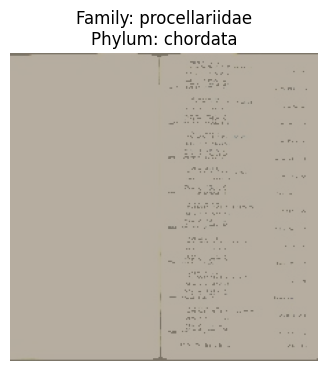

Images batch shape: (16, 224, 224, 3)
Phyla indices batch shape: (16,)
Family indices batch shape: (16,)


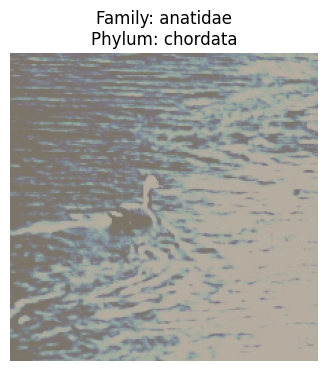

Images batch shape: (16, 224, 224, 3)
Phyla indices batch shape: (16,)
Family indices batch shape: (16,)


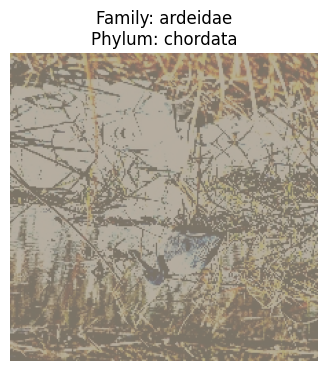

Images batch shape: (16, 224, 224, 3)
Phyla indices batch shape: (16,)
Family indices batch shape: (16,)


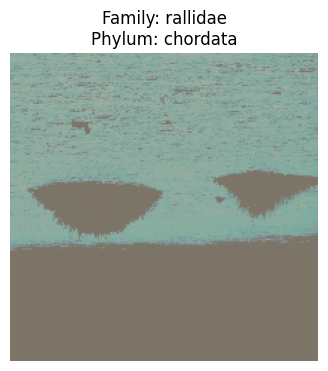

Images batch shape: (16, 224, 224, 3)
Phyla indices batch shape: (16,)
Family indices batch shape: (16,)


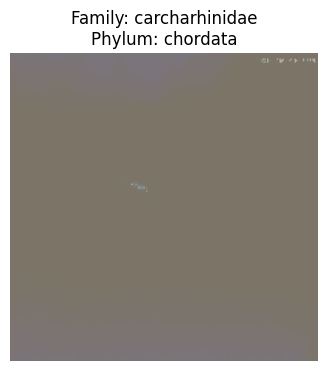

Images batch shape: (16, 224, 224, 3)
Phyla indices batch shape: (16,)
Family indices batch shape: (16,)


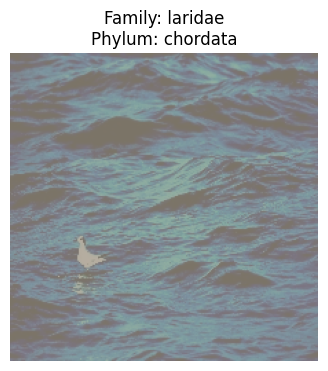

Images batch shape: (16, 224, 224, 3)
Phyla indices batch shape: (16,)
Family indices batch shape: (16,)


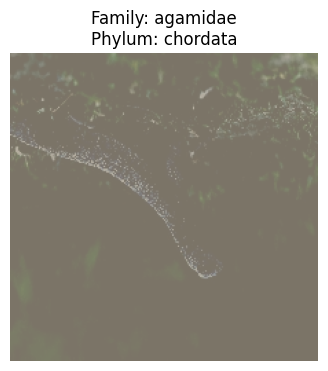

Images batch shape: (16, 224, 224, 3)
Phyla indices batch shape: (16,)
Family indices batch shape: (16,)


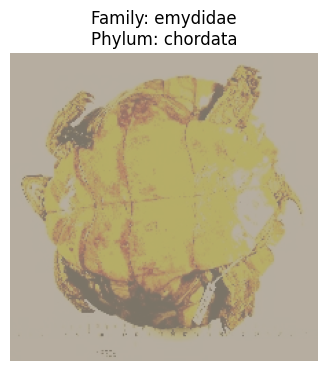

Images batch shape: (16, 224, 224, 3)
Phyla indices batch shape: (16,)
Family indices batch shape: (16,)


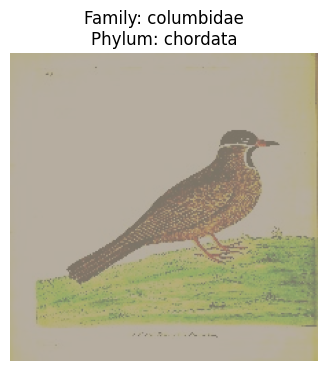

Images batch shape: (16, 224, 224, 3)
Phyla indices batch shape: (16,)
Family indices batch shape: (16,)


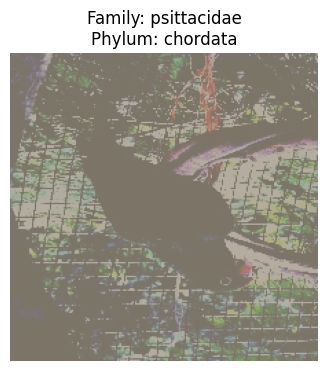

In [17]:
if not metadata.empty:
    # Validate data
    metadata_validated = load_and_validate_data(DATA_PATH, metadata.copy()) # Use copy to avoid modifying original

    if not metadata_validated.empty:
        # Analyze distribution of validated data
        analyze_class_distribution(metadata_validated)

        # Create datasets using validated data
        # This line calls create_datasets and unpacks its return values
        train_ds, val_ds, family_lookup, phylum_lookup, train_fams, val_fams = create_datasets(metadata_validated, augment_version='v3')

        # Check if datasets were created successfully
        # The check below handles the case where create_datasets returned None due to empty split
        if train_ds and val_ds and family_lookup and phylum_lookup:
            NUM_FAMILIES = family_lookup.vocabulary_size()
            NUM_PHYLA = phylum_lookup.vocabulary_size()
            print(f"\nNumber of family classes: {NUM_FAMILIES}")
            print(f"Number of phylum classes: {NUM_PHYLA}")

            # Optional: Inspect a batch from the training dataset
            print("\nInspecting a batch from the training dataset:")
            for (images, phyla_indices), family_indices in train_ds.take(10):
                print("Images batch shape:", images.shape)
                print("Phyla indices batch shape:", phyla_indices.shape)
                print("Family indices batch shape:", family_indices.shape)
                # Display the first image in the batch
                plt.figure(figsize=(4, 4))
                # Denormalize image for display: (image * std) + mean
                display_img = (images[0].numpy() * IMAGENET_STD.numpy() + IMAGENET_MEAN.numpy()).clip(0, 1)
                plt.imshow(display_img)
                # Get the string labels for the first item
                fam_label_idx = family_indices[0].numpy()
                phy_label_idx = phyla_indices[0].numpy()
                # Handle potential index out of bounds if lookup failed for some reason
                fam_label = family_lookup.get_vocabulary()[fam_label_idx] if fam_label_idx < NUM_FAMILIES else "Unknown"
                phy_label = phylum_lookup.get_vocabulary()[phy_label_idx] if phy_label_idx < NUM_PHYLA else "Unknown"
                plt.title(f"Family: {fam_label}\nPhylum: {phy_label}")
                plt.axis("off")
                plt.show()
        else:
            print("Failed to create datasets or unpack results from create_datasets.")
            # Set flags or exit if datasets are crucial
            # sys.exit("Dataset creation failed.")
    else:
        print("No valid data found after validation.")
        # sys.exit("No valid data.")
else:
    print("Metadata loading failed, cannot proceed.")
    # sys.exit("Metadata loading failed.")

In [18]:
def build_custom_cnn(num_phyla, num_families):
    """
    Builds a simple custom CNN model for image classification with auxiliary phylum input.

    Requires:
        - num_phyla (int): Number of unique phylum classes (for embedding layer).
        - num_families (int): Number of output classes (families) for softmax classification.

    Ensures:
        - Image input passes through 3 convolutional + pooling blocks.
        - Phylum input is embedded and concatenated with visual features.
        - Fully connected layers apply dropout regularization to prevent overfitting.
        - Output layer predicts one of the family classes via softmax.

    Returns:
        - model (tf.keras.Model): Compiled Keras model ready for training.
    """

    img_input = tf.keras.Input(shape=(224, 224, 3), name="image")
    phylum_input = tf.keras.Input(shape=(), dtype=tf.int32, name="phylum")

    x = tf.keras.layers.Conv2D(32, 3, activation='relu', padding='same')(img_input)
    x = tf.keras.layers.MaxPooling2D()(x)
    x = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')(x)
    x = tf.keras.layers.MaxPooling2D()(x)
    x = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')(x)
    x = tf.keras.layers.Flatten()(x)

    phylum_embed = tf.keras.layers.Embedding(input_dim=num_phyla, output_dim=16)(phylum_input)
    phylum_embed = tf.keras.layers.Flatten()(phylum_embed)

    concat = tf.keras.layers.Concatenate()([x, phylum_embed])
    x = tf.keras.layers.Dense(256, activation='relu')(concat)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    output = tf.keras.layers.Dense(num_families, activation='softmax')(x)

    return tf.keras.Model(inputs=[img_input, phylum_input], outputs=output, name="CustomCNN")

Epoch 1/20
525/525 ━━━━━━━━━━━━━━━━━━━━ 220s 407ms/step - accuracy: 0.0311 - loss: 5.4465 - val_accuracy: 0.0353 - val_loss: 5.0939
Epoch 2/20
525/525 ━━━━━━━━━━━━━━━━━━━━ 280s 447ms/step - accuracy: 0.0901 - loss: 4.4791 - val_accuracy: 0.0723 - val_loss: 5.4484
Epoch 3/20
525/525 ━━━━━━━━━━━━━━━━━━━━ 208s 395ms/step - accuracy: 0.1207 - loss: 4.2068 - val_accuracy: 0.0737 - val_loss: 5.1773
Epoch 4/20
525/525 ━━━━━━━━━━━━━━━━━━━━ 289s 447ms/step - accuracy: 0.1670 - loss: 3.8702 - val_accuracy: 0.0729 - val_loss: 4.6332
Epoch 5/20
525/525 ━━━━━━━━━━━━━━━━━━━━ 239s 456ms/step - accuracy: 0.2386 - loss: 3.4672 - val_accuracy: 0.0745 - val_loss: 4.8368
Epoch 6/20
525/525 ━━━━━━━━━━━━━━━━━━━━ 232s 397ms/step - accuracy: 0.3110 - loss: 3.0419 - val_accuracy: 0.0640 - val_loss: 5.2519
Epoch 7/20
525/525 ━━━━━━━━━━━━━━━━━━━━ 237s 452ms/step - accuracy: 0.3875 - loss: 2.6585 - val_accuracy: 0.0670 - val_loss: 5.5557
Epoch 8/20
525/525 ━━━━━━━━━━━━━━━━━━━━ 239s 455ms/step - accuracy: 0.4709 -

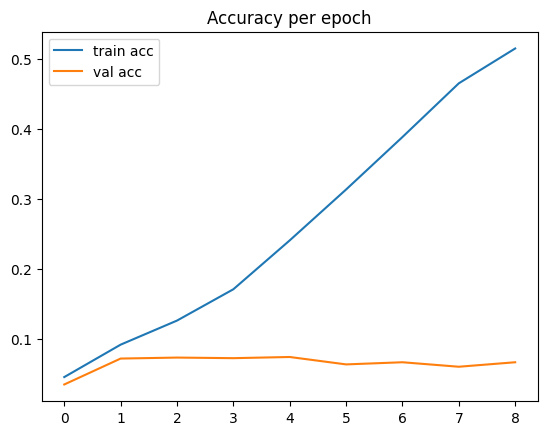

In [19]:
model_cnn3 = build_custom_cnn(NUM_PHYLA, NUM_FAMILIES)

# Compile the model
model_cnn3.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="sparse_categorical_crossentropy",  # For multi-class classification
    metrics=["accuracy"]
)

history = model_cnn3.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
    ]
)

plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.title("Accuracy per epoch")
plt.show()